In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import pickle
import random

# General Backtest Class

In [9]:
class Backtest:
    def __init__(self,price_data,initial_amount,strategy):
        if self.check_input_data(price_data) == True:
            self.df = price_data
        else:
            return
        self.positions = {}
        self.cash = initial_amount
        self.values = []
        self.strategy = strategy
    
    def check_input_data(self,df):
        if df.index.inferred_type != "datetime64":
            print("input dataframe must have a datetime64 index")
            return False
        if df.isnull().values.any():
            print("input dataframe contains null values")
            return False
        return True
    
    def update_positions(self,ti):
        current_price = self.df.loc[ti]
        for position in list(self.positions.values()):
            position.price = current_price[position.ticker]
        
        total_position_value = sum([pos.price*pos.shares for pos in self.positions.values()])
        self.values.append(total_position_value+self.cash)
    
    def show_status(self):
        print("cash: {}".format(self.cash))
        print("# of positions: {}".format(len(self.positions)))
        
        for pos in self.positions.values():
            pos.show()
        total_position_value = sum([pos.price*pos.shares for pos in self.positions.values()])
        print("total_position_value: {}".format(total_position_value))
    
        
    def backtest(self):
        
    
        for ti in self.df.index:
            print("=====================================================================")
            print(ti)
            self.update_positions(ti)
            if ti.hour == 9:
                self.show_status()
            
            
            
            #where the strategy kick in and gives a list of bids
            bid_list = self.strategy(ti,self.df.loc[:ti],self.positions,self.cash)
            for bid in bid_list:
                print("Biding:\n")
                bid.show()
            
            
            
            #process the bids
            for bid in bid_list:
                #if already have a positionn
                if bid.ticker in self.positions.keys():
                    pos = self.positions[bid.ticker]
                    
                    #if increase position
                    if bid.bid_type == 1:
                        cost = bid.shares * bid.price
                        if self.cash < cost:
                            print("Not enough cash to build a position for "+bid.ticker)
                            continue
                        self.cash -= cost
                        pos.change_position(bid)
                    
                    #if decrease position
                    else:
                        if self.positions[bid.ticker].shares < bid.shares:
                            print("Try to sell {} shares, but only got {} shares.".format(bid.shares,self.positions[bid.ticker].shares))
                            continue
                            
                        pos.change_position(bid)
                        self.cash += bid.shares * bid.price
                        if pos.shares == 0:
                            del pos
                    
                    self.positions[bid.ticker].change_position(bid)
                    
                
                #if not have a position yet
                else:
                    cost = bid.shares * bid.price
                    if self.cash < cost:
                        print("Not enough cash to build a position for "+bid.ticker)
                        continue
                    self.cash -= cost
                    self.positions[bid.ticker] = Position(bid)

# A simple strategy for demo purposes

In [10]:
def my_strategy(ti,df,positions):
    res = []
    prices = df.iloc[-1]
    ticker = random.choice(list(df.columns))
    if ti.hour == 9:
        bid = Bid(ticker = ticker,shares = 3,price = prices[ticker],bid_type = 1)
        res.append(bid)
    
    return res

In [35]:
def BAH(ti,df,positions,cash):
    res = []
    if ti == df.index[0]:
        
        count = len(df.columns)
        weight = cash//count
        
        #Latest price
        prices = df.iloc[-1]
        for ticker in df.columns:
            price = prices[ticker]
            bid = Bid(ticker = ticker, shares = weight//price,price = price, bid_type = 1)
            res.append(bid)
    return res

# Bid and positions class

In [32]:
class Bid:
    def __init__(self,ticker,price,shares,bid_type):
        self.ticker = ticker
        self.price = price
        self.shares = shares
        self.bid_type = bid_type
    
    def show(self):
        print("Ticker: {}".format(self.ticker))
        print("Shares: {}".format(self.shares))
        print("price: {}".format(self.price))

class Position:
    def __init__(self,bid):
        self.ticker = bid.ticker
        self.shares = bid.shares
        self.price = bid.price

    
    def change_position(self,bid):
        if bid.bid_type == 1:
            self.shares += bid.shares
        
        if bid.bid_type == 0:
            self.shares -= bid.shares
    
    def show(self):
        print("Ticker: {}".format(self.ticker))
        print("Shares: {}".format(self.shares))
        print("price: {}".format(self.price))

# Demo
## sp100 data for 15 day with 15min interval 
## input data must have a datetime index and must not contain null values

In [22]:

with open("sp100tickers.pickle", "rb") as f:
            tickers = pickle.load(f)

data =  yf.download(tickers = tickers, 
period = "", interval = "15m", group_by = 'ticker',
auto_adjust = True,
prepost = False,
threads = True,
proxy = None
)

data = data.loc[:, pd.IndexSlice[:, ['Close']]]

columns = data.columns.droplevel(1)

data.columns = columns 

data.sort_index(axis = 1, inplace = True)
data = data.fillna(method = "bfill")

[*********************100%***********************]  100 of 100 completed


In [37]:
bt = Backtest(data.dropna(axis = 0),100000,BAH)

In [49]:
data.index

DatetimeIndex(['2022-08-17 09:30:00-04:00', '2022-08-17 09:45:00-04:00',
               '2022-08-17 10:00:00-04:00', '2022-08-17 10:15:00-04:00',
               '2022-08-17 10:30:00-04:00', '2022-08-17 10:45:00-04:00',
               '2022-08-17 11:00:00-04:00', '2022-08-17 11:15:00-04:00',
               '2022-08-17 11:30:00-04:00', '2022-08-17 11:45:00-04:00',
               ...
               '2022-09-07 14:22:51-04:00', '2022-09-07 14:22:52-04:00',
               '2022-09-07 14:22:53-04:00', '2022-09-07 14:22:54-04:00',
               '2022-09-07 14:22:55-04:00', '2022-09-07 14:22:56-04:00',
               '2022-09-07 14:22:57-04:00', '2022-09-07 14:22:58-04:00',
               '2022-09-07 14:22:59-04:00', '2022-09-07 14:23:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=413, freq=None)

In [38]:
bt.backtest()

2022-08-17 09:30:00-04:00
cash: 100000
# of positions: 0
total_position_value: 0
Biding:

Ticker: AAPL
Shares: 5.0
price: 173.57000732421875
Biding:

Ticker: ABBV
Shares: 7.0
price: 141.6699981689453
Biding:

Ticker: ABT
Shares: 8.0
price: 111.25
Biding:

Ticker: ACN
Shares: 3.0
price: 319.68499755859375
Biding:

Ticker: ADBE
Shares: 2.0
price: 440.1098937988281
Biding:

Ticker: AIG
Shares: 17.0
price: 56.959999084472656
Biding:

Ticker: AMGN
Shares: 3.0
price: 250.3000030517578
Biding:

Ticker: AMT
Shares: 3.0
price: 276.55999755859375
Biding:

Ticker: AMZN
Shares: 7.0
price: 141.86000061035156
Biding:

Ticker: AVGO
Shares: 1.0
price: 539.9650268554688
Biding:

Ticker: AXP
Shares: 6.0
price: 163.08639526367188
Biding:

Ticker: BA
Shares: 5.0
price: 167.35079956054688
Biding:

Ticker: BAC
Shares: 27.0
price: 36.474998474121094
Biding:

Ticker: BK
Shares: 22.0
price: 44.720001220703125
Biding:

Ticker: BKNG
Shares: 0.0
price: 2108.75
Biding:

Ticker: BLK
Shares: 1.0
price: 744.450012207

price: 44.19499969482422
Ticker: WBA
Shares: 23.0
price: 38.314998626708984
Ticker: WFC
Shares: 21.0
price: 45.79499816894531
Ticker: WMT
Shares: 7.0
price: 138.2899932861328
Ticker: XOM
Shares: 10.0
price: 94.52999877929688
total_position_value: 90168.29949188232
2022-08-19 09:45:00-04:00
cash: 9347.680362701416
# of positions: 100
Ticker: AAPL
Shares: 5.0
price: 172.77000427246094
Ticker: ABBV
Shares: 7.0
price: 142.33999633789062
Ticker: ABT
Shares: 8.0
price: 109.86000061035156
Ticker: ACN
Shares: 3.0
price: 314.8399963378906
Ticker: ADBE
Shares: 2.0
price: 424.8999938964844
Ticker: AIG
Shares: 17.0
price: 56.61000061035156
Ticker: AMGN
Shares: 3.0
price: 250.58999633789062
Ticker: AMT
Shares: 3.0
price: 274.94000244140625
Ticker: AMZN
Shares: 7.0
price: 139.23500061035156
Ticker: AVGO
Shares: 1.0
price: 550.5999755859375
Ticker: AXP
Shares: 6.0
price: 162.48500061035156
Ticker: BA
Shares: 5.0
price: 164.42999267578125
Ticker: BAC
Shares: 27.0
price: 35.720001220703125
Ticker: BK
S

2022-08-22 12:45:00-04:00
2022-08-22 13:00:00-04:00
2022-08-22 13:15:00-04:00
2022-08-22 13:30:00-04:00
2022-08-22 13:45:00-04:00
2022-08-22 14:00:00-04:00
2022-08-22 14:15:00-04:00
2022-08-22 14:30:00-04:00
2022-08-22 14:45:00-04:00
2022-08-22 15:00:00-04:00
2022-08-22 15:15:00-04:00
2022-08-22 15:30:00-04:00
2022-08-22 15:45:00-04:00
2022-08-23 09:30:00-04:00
cash: 9347.680362701416
# of positions: 100
Ticker: AAPL
Shares: 5.0
price: 167.1699981689453
Ticker: ABBV
Shares: 7.0
price: 138.74000549316406
Ticker: ABT
Shares: 8.0
price: 105.625
Ticker: ACN
Shares: 3.0
price: 308.3299865722656
Ticker: ADBE
Shares: 2.0
price: 409.92999267578125
Ticker: AIG
Shares: 17.0
price: 54.349998474121094
Ticker: AMGN
Shares: 3.0
price: 245.05999755859375
Ticker: AMT
Shares: 3.0
price: 265.0
Ticker: AMZN
Shares: 7.0
price: 132.9600067138672
Ticker: AVGO
Shares: 1.0
price: 531.6599731445312
Ticker: AXP
Shares: 6.0
price: 158.3300018310547
Ticker: BA
Shares: 5.0
price: 159.25999450683594
Ticker: BAC
Sha

Shares: 8.0
price: 105.27999877929688
Ticker: ACN
Shares: 3.0
price: 304.739990234375
Ticker: ADBE
Shares: 2.0
price: 408.3599853515625
Ticker: AIG
Shares: 17.0
price: 54.0
Ticker: AMGN
Shares: 3.0
price: 242.6300048828125
Ticker: AMT
Shares: 3.0
price: 264.3949890136719
Ticker: AMZN
Shares: 7.0
price: 133.86000061035156
Ticker: AVGO
Shares: 1.0
price: 524.8200073242188
Ticker: AXP
Shares: 6.0
price: 157.36000061035156
Ticker: BA
Shares: 5.0
price: 162.94000244140625
Ticker: BAC
Shares: 27.0
price: 34.150001525878906
Ticker: BK
Shares: 22.0
price: 42.77989959716797
Ticker: BKNG
Shares: 0.0
price: 2005.5360107421875
Ticker: BLK
Shares: 1.0
price: 696.010009765625
Ticker: BMY
Shares: 13.0
price: 72.75499725341797
Ticker: C
Shares: 18.0
price: 50.665000915527344
Ticker: CAT
Shares: 5.0
price: 196.38999938964844
Ticker: CHTR
Shares: 2.0
price: 436.92999267578125
Ticker: CL
Shares: 12.0
price: 80.87999725341797
Ticker: CMCSA
Shares: 25.0
price: 37.20000076293945
Ticker: COF
Shares: 8.0
pric

price: 142.90499877929688
Ticker: MO
Shares: 21.0
price: 46.52000045776367
Ticker: MRK
Shares: 11.0
price: 90.64089965820312
Ticker: MS
Shares: 10.0
price: 90.18000030517578
Ticker: MSFT
Shares: 3.0
price: 279.6099853515625
Ticker: NEE
Shares: 11.0
price: 90.20539855957031
Ticker: NFLX
Shares: 4.0
price: 233.99000549316406
Ticker: NKE
Shares: 8.0
price: 112.67500305175781
Ticker: NVDA
Shares: 5.0
price: 176.9949951171875
Ticker: ORCL
Shares: 12.0
price: 77.08999633789062
Ticker: PEP
Shares: 5.0
price: 179.6300048828125
Ticker: PFE
Shares: 20.0
price: 47.79029846191406
Ticker: PG
Shares: 6.0
price: 145.7899932861328
Ticker: PM
Shares: 9.0
price: 98.08999633789062
Ticker: PYPL
Shares: 10.0
price: 96.30999755859375
Ticker: QCOM
Shares: 6.0
price: 146.3000030517578
Ticker: RTX
Shares: 10.0
price: 96.19499969482422
Ticker: SBUX
Shares: 11.0
price: 87.44999694824219
Ticker: SCHW
Shares: 13.0
price: 74.02999877929688
Ticker: SO
Shares: 12.0
price: 79.34500122070312
Ticker: SPG
Shares: 8.0
pri

price: 677.27001953125
Ticker: BMY
Shares: 13.0
price: 67.0199966430664
Ticker: C
Shares: 18.0
price: 49.400001525878906
Ticker: CAT
Shares: 5.0
price: 187.42999267578125
Ticker: CHTR
Shares: 2.0
price: 417.29998779296875
Ticker: CL
Shares: 12.0
price: 79.91999816894531
Ticker: CMCSA
Shares: 25.0
price: 36.25
Ticker: COF
Shares: 8.0
price: 107.04000091552734
Ticker: COP
Shares: 9.0
price: 110.33499908447266
Ticker: COST
Shares: 1.0
price: 531.4400024414062
Ticker: CRM
Shares: 5.0
price: 163.27999877929688
Ticker: CSCO
Shares: 21.0
price: 45.560001373291016
Ticker: CVS
Shares: 9.0
price: 99.87999725341797
Ticker: CVX
Shares: 6.0
price: 160.55999755859375
Ticker: DD
Shares: 16.0
price: 57.79999923706055
Ticker: DHR
Shares: 3.0
price: 276.9549865722656
Ticker: DIS
Shares: 8.0
price: 113.27999877929688
Ticker: DOW
Shares: 18.0
price: 52.2599983215332
Ticker: DUK
Shares: 8.0
price: 109.0999984741211
Ticker: EMR
Shares: 11.0
price: 84.19000244140625
Ticker: EXC
Shares: 21.0
price: 44.6699981

2022-08-31 12:45:00-04:00
2022-08-31 13:00:00-04:00
2022-08-31 13:15:00-04:00
2022-08-31 13:30:00-04:00
2022-08-31 13:45:00-04:00
2022-08-31 14:00:00-04:00
2022-08-31 14:15:00-04:00
2022-08-31 14:30:00-04:00
2022-08-31 14:45:00-04:00
2022-08-31 15:00:00-04:00
2022-08-31 15:15:00-04:00
2022-08-31 15:30:00-04:00
2022-08-31 15:45:00-04:00
2022-09-01 09:30:00-04:00
cash: 9347.680362701416
# of positions: 100
Ticker: AAPL
Shares: 5.0
price: 156.9990997314453
Ticker: ABBV
Shares: 7.0
price: 135.58999633789062
Ticker: ABT
Shares: 8.0
price: 102.48999786376953
Ticker: ACN
Shares: 3.0
price: 287.1400146484375
Ticker: ADBE
Shares: 2.0
price: 368.25
Ticker: AIG
Shares: 17.0
price: 51.38999938964844
Ticker: AMGN
Shares: 3.0
price: 241.8699951171875
Ticker: AMT
Shares: 3.0
price: 253.72000122070312
Ticker: AMZN
Shares: 7.0
price: 126.94999694824219
Ticker: AVGO
Shares: 1.0
price: 486.4599914550781
Ticker: AXP
Shares: 6.0
price: 149.5800018310547
Ticker: BA
Shares: 5.0
price: 155.5800018310547
Ticke

2022-09-02 12:30:00-04:00
2022-09-02 12:45:00-04:00
2022-09-02 13:00:00-04:00
2022-09-02 13:15:00-04:00
2022-09-02 13:30:00-04:00
2022-09-02 13:45:00-04:00
2022-09-02 14:00:00-04:00
2022-09-02 14:15:00-04:00
2022-09-02 14:30:00-04:00
2022-09-02 14:45:00-04:00
2022-09-02 15:00:00-04:00
2022-09-02 15:15:00-04:00
2022-09-02 15:30:00-04:00
2022-09-02 15:45:00-04:00
2022-09-06 09:30:00-04:00
cash: 9347.680362701416
# of positions: 100
Ticker: AAPL
Shares: 5.0
price: 155.80999755859375
Ticker: ABBV
Shares: 7.0
price: 137.2100067138672
Ticker: ABT
Shares: 8.0
price: 102.5199966430664
Ticker: ACN
Shares: 3.0
price: 282.5899963378906
Ticker: ADBE
Shares: 2.0
price: 368.67999267578125
Ticker: AIG
Shares: 17.0
price: 52.595001220703125
Ticker: AMGN
Shares: 3.0
price: 243.99000549316406
Ticker: AMT
Shares: 3.0
price: 251.50999450683594
Ticker: AMZN
Shares: 7.0
price: 127.05000305175781
Ticker: AVGO
Shares: 1.0
price: 498.0199890136719
Ticker: AXP
Shares: 6.0
price: 149.11000061035156
Ticker: BA
Sh

Shares: 11.0
price: 82.25
Ticker: SCHW
Shares: 13.0
price: 70.0199966430664
Ticker: SO
Shares: 12.0
price: 78.5
Ticker: SPG
Shares: 8.0
price: 99.80999755859375
Ticker: T
Shares: 54.0
price: 17.070100784301758
Ticker: TGT
Shares: 5.0
price: 161.22999572753906
Ticker: TMO
Shares: 1.0
price: 548.97998046875
Ticker: TMUS
Shares: 6.0
price: 142.75999450683594
Ticker: TSLA
Shares: 3.0
price: 269.32989501953125
Ticker: TXN
Shares: 5.0
price: 163.5
Ticker: UNH
Shares: 1.0
price: 523.8200073242188
Ticker: UNP
Shares: 4.0
price: 226.27999877929688
Ticker: UPS
Shares: 4.0
price: 192.6699981689453
Ticker: USB
Shares: 20.0
price: 45.222900390625
Ticker: V
Shares: 4.0
price: 197.9949951171875
Ticker: VZ
Shares: 22.0
price: 41.63999938964844
Ticker: WBA
Shares: 23.0
price: 35.34000015258789
Ticker: WFC
Shares: 21.0
price: 42.87900161743164
Ticker: WMT
Shares: 7.0
price: 131.49000549316406
Ticker: XOM
Shares: 10.0
price: 95.63999938964844
total_position_value: 83592.60024261475
2022-09-06 10:00:00-04

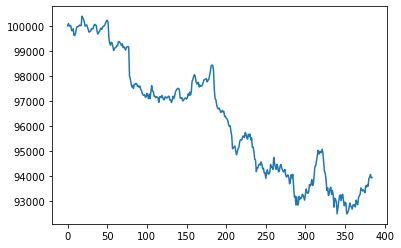

In [41]:
import matplotlib.pyplot as plt
plt.plot(bt.values)